# Modelling fluid flows

- Importing modules

In [4]:
!ls

README.md  data  notebook  src


In [12]:
!pip install numpy pandas scipy matplotlib seaborn scikit-learn pysindy pydmd setuptools


In [13]:
import pysindy as ps
import pydmd as pdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

## Data Visualization

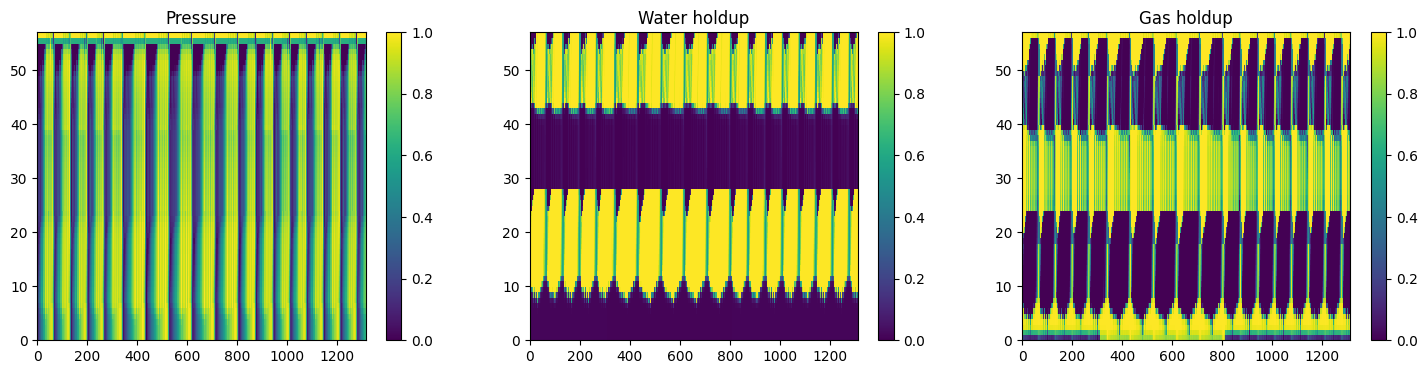

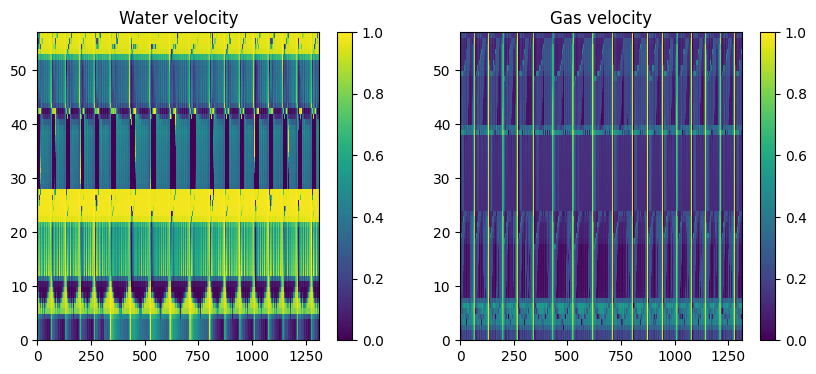

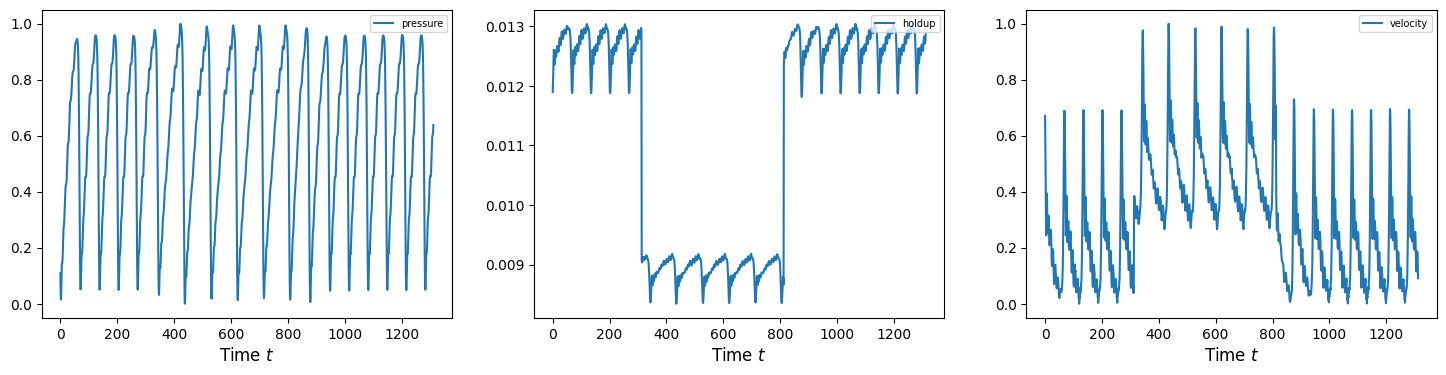

In [14]:


path = r'./data/'
df0 = pd.read_csv(path + 'pressure.csv', index_col=False, header=None)

df1 = pd.read_csv(path + 'water_holdup.csv', index_col=False, header=None)

df2 = pd.read_csv(path + 'water_velocity.csv', index_col=False, header=None)

df3 = pd.read_csv(path + 'gas_holdup.csv', index_col=False, header=None)

df4 = pd.read_csv(path + 'gas_velocity.csv', index_col=False, header=None)

df5 = pd.read_csv(path + 'x.csv', index_col=False, header=None)

df6 = pd.read_csv(path + 't.csv', index_col=False, header=None)

t_start = 0 

x_end = 57

x = df5.iloc[:x_end,0].to_numpy()

t = df6.iloc[t_start:,0].T.to_numpy()

pressure = df0.iloc[t_start:,:x_end].to_numpy().T

water_holdup = df1.iloc[t_start:,:x_end].to_numpy().T

water_velocity = df2.iloc[t_start:,:x_end].to_numpy().T

gas_holdup = df3.iloc[t_start:,:x_end].to_numpy().T

gas_velocity = df4.iloc[t_start:,:x_end].to_numpy().T

L = x[-1] # length of spatial domain
N = len(x) # number of spatial points in [0,L]

T = t[-1] # total time
Nt = len(t) # number of temporal points in [0,T]
#Input data

plt.figure(figsize=(18,4))

plt.subplot(1, 3, 1)
plt.title("Pressure")
plt.pcolor(pressure)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("Water holdup")
plt.pcolor(water_holdup)
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("Gas holdup")
plt.pcolor(gas_holdup)
plt.colorbar()
plt.show()
#Output data

plt.figure(figsize=(10,4))

plt.subplot(1, 2, 1)

plt.subplot(1, 2, 1)
plt.title("Water velocity")
plt.pcolor(water_velocity)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Gas velocity")
plt.pcolor(gas_velocity)
plt.colorbar()
plt.show()

x_location = 0

plt.figure(figsize=(18,4))

plt.subplot(1, 3, 1)
plt.plot(pressure.T[:,x_location],'-',label='pressure')
plt.xlabel('Time $t$', fontsize=12)
plt.legend(loc = 1, fontsize = 7)

plt.subplot(1, 3, 2)
plt.plot(water_holdup.T[:,x_location],'-',label='holdup')
plt.xlabel('Time $t$', fontsize=12)
plt.legend(loc = 1, fontsize = 7)

plt.subplot(1, 3, 3)
plt.plot(water_velocity.T[:,x_location],'-',label='velocity')
plt.xlabel('Time $t$', fontsize=12)
plt.legend(loc = 1, fontsize = 7)

plt.show()

## Building the data matrix